In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

sp500 = yf.download('^GSPC', start='1990-01-01', end='2024-03-18')
sp500_future = yf.download('ES=F', start='1990-01-01', end='2024-03-18')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


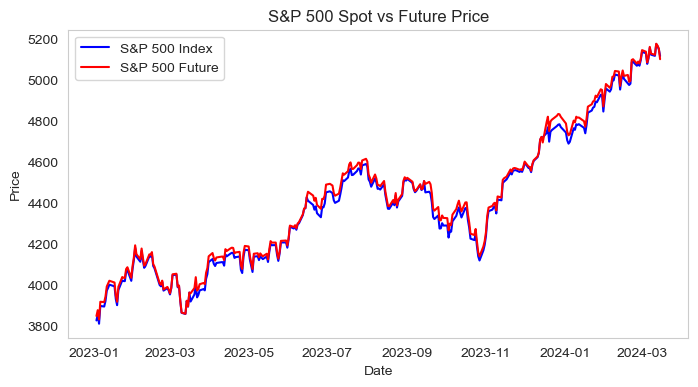

In [65]:
plt.figure(figsize=(8, 4))
plt.plot(sp500['Close']['2023':], label='S&P 500 Index', color='blue')
plt.plot(sp500_future['Close']['2023':], label='S&P 500 Future', color='red')
plt.title('S&P 500 Spot vs Future Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.legend()
plt.show()

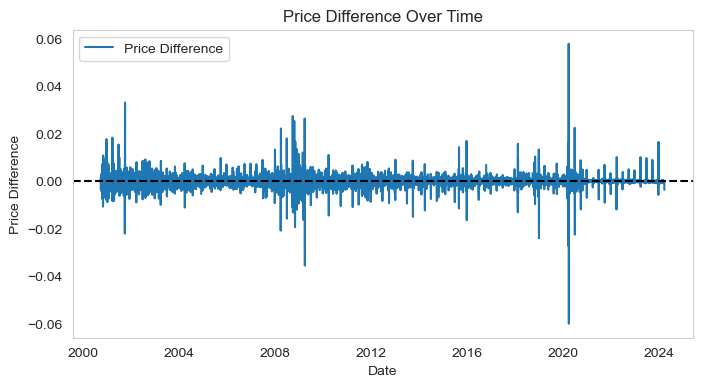

In [6]:
price_diff = sp500_future['Close'].pct_change() - sp500['Close'].pct_change()
plt.figure(figsize=(8, 4))
plt.plot(price_diff, label='Price Difference')
plt.title('Price Difference Over Time')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.axhline(0, color='black', linestyle='--') 
plt.legend()
plt.grid(False)
plt.show()

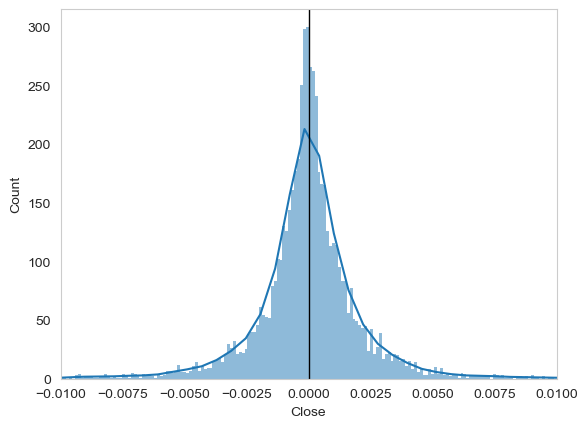

In [18]:
import seaborn as sns
sns.histplot(
    price_diff,
    bins = 1000,
    edgecolor = 'none',
    kde = True
)
plt.grid(False)
plt.xlim(
    [-0.01, 0.01]
)
plt.axvline(0, color = 'k', lw = 1)
plt.show()

#### 선물의 가격은 시장의 기대(Expectation)을 반영할까?

In [19]:
future_ret = sp500_future['Close'].pct_change()
ret = sp500['Close'].pct_change()

In [26]:
matrix = pd.concat([
    ret, future_ret
], axis = 1)
matrix.columns = ['underline','futures']
matrix.fillna(0, inplace = True)

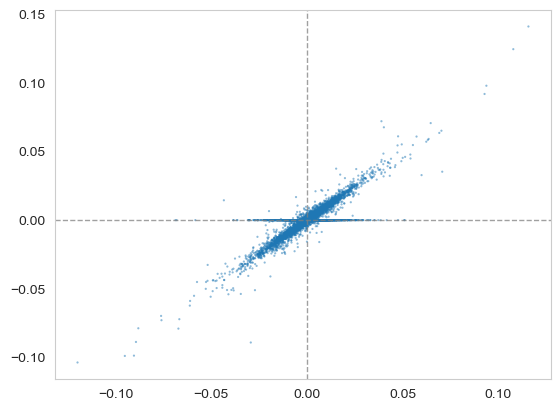

In [40]:
plt.scatter(
    matrix['underline'],
    matrix['futures'],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.grid(False)
plt.show()

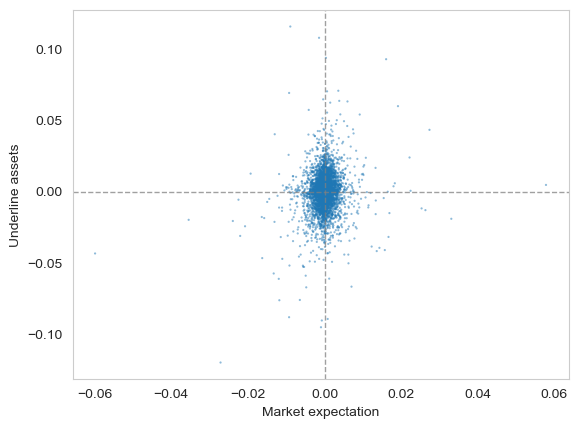

In [68]:
plt.scatter(
    (matrix['futures'] - matrix['underline'])['2001':],
    matrix['underline'].shift(1)['2001':],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.ylabel('Underline assets')
plt.xlabel('Market expectation')
plt.grid(False)
plt.show()

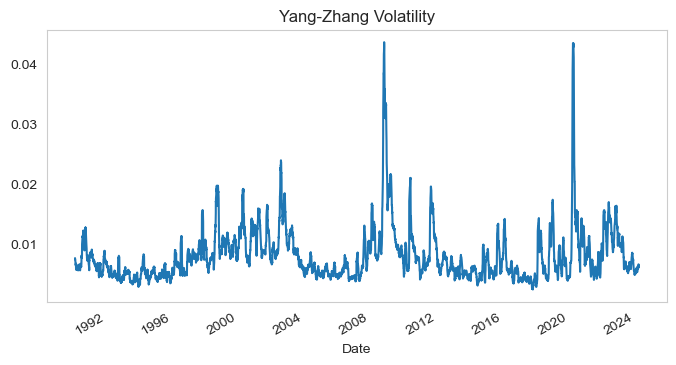

In [49]:
from FinancialMachineLearning.features.volatility import *

yang_zhang_volatility(sp500).plot(
    figsize = (8, 4),
    title = 'Yang-Zhang Volatility',
    grid = False
)
plt.show()

In [53]:
matrix

,underline,futures
Date,,
1990-01-02,0.000000,0.000000
1990-01-03,-0.002586,0.000000
1990-01-04,-0.008613,0.000000
1990-01-05,-0.009756,0.000000
1990-01-08,0.004514,0.000000
...,...,...
2024-03-11,-0.001122,-0.001170
2024-03-12,0.011202,0.010589
2024-03-13,-0.001925,-0.001787


In [54]:
matrix = pd.concat(
    [matrix, yang_zhang_volatility(sp500)], axis = 1
)
matrix.columns = ['underline', 'futures', 'volatility']

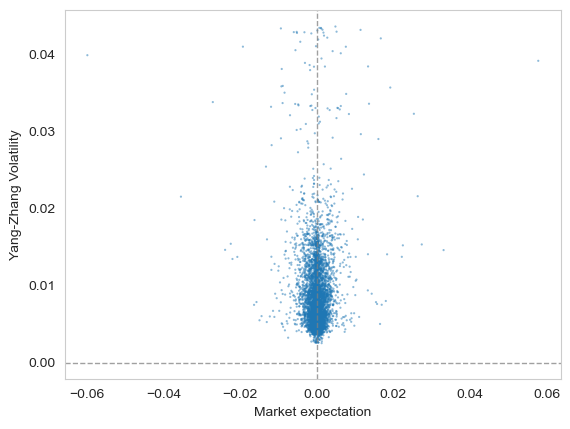

In [72]:
plt.scatter(
    (matrix['futures'] - matrix['underline'])['2001':],
    matrix['volatility'].shift(1)['2001':],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.ylabel('Yang-Zhang Volatility')
plt.xlabel('Market expectation')
plt.grid(False)
plt.show()

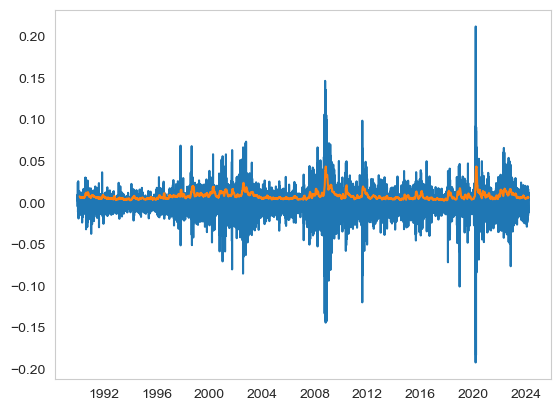

In [69]:
plt.plot(matrix['futures'].shift(1)[1:] - matrix['underline'][1:])
plt.plot(matrix['volatility'])
plt.grid(False)
plt.show()

In [73]:
matrix_models = matrix['2001':]

In [89]:
import warnings
warnings.filterwarnings('ignore')

matrix_models['market_expectation'] = matrix_models['futures'] - matrix_models['underline']
matrix_models.dropna(inplace = True)

In [96]:
import statsmodels.api as sm

X = matrix_models[['market_expectation']][1:]
X = sm.add_constant(X)
y = matrix_models['underline'].shift(1)[1:]

In [97]:
model = sm.OLS(y, X).fit()

In [98]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              underline   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     104.5
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           2.50e-24
Time:                        00:27:10   Log-Likelihood:                 17463.
No. Observations:                5836   AIC:                        -3.492e+04
Df Residuals:                    5834   BIC:                        -3.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003      0

OLS추정결과, p-value가 0에 거의 가깝게 나온다. $R^2$값이 0.018정도로 매우 낮긴 하지만, 전체 변동 중 0.018정도의 변동을 설명할 수 있는 요인이 될 수도 있다는 의미가 내포되어 있기 때문에 무시하기는 어렵다

#### Conclusion

시장의 기대를 선물과 index 증가율의 차로 계산한 것은 충분히 연구할만한 factor가 될 수도 있다

#### 생각해볼 만한 주제들

- Contango market, Back wardation market과 Regime은 어떤 관계가 있을까?
- 인과 검정을 할 수 있는 방법이 없을까?
- 만기에 다가올 수록 기초자산에 수렴하는데 이 기간동안 해석은 어떻게 해야할까?